In [2]:
import pandas as pd
import numpy as np


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('final_imputed_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   property_type             17880 non-null  object 
 1   price                     17880 non-null  float64
 2   carpet_area               17880 non-null  float64
 3   bedroom                   17880 non-null  float64
 4   bathroom                  17880 non-null  float64
 5   status                    17880 non-null  object 
 6   transaction_type          17880 non-null  object 
 7   additional_room           17880 non-null  float64
 8   regions                   17880 non-null  object 
 9   balconies_imputed         17676 non-null  float64
 10  balconies_iter            17880 non-null  float64
 11  floorNum_iter             17880 non-null  float64
 12  furnished_status_imputed  17880 non-null  int64  
 13  luxury_score_iter         17880 non-null  float64
 14  luxury

In [44]:
df['status'] = df['status'].fillna('ready to move')

In [42]:
df['floorNum_iter'] = df['floorNum_iter'].round()

## luxury Score

<Axes: ylabel='luxury_score_iter'>

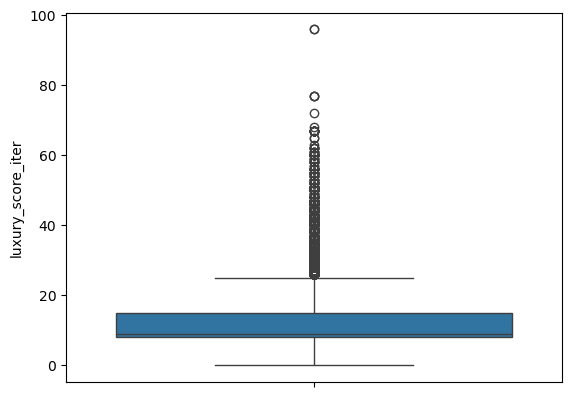

In [15]:
sns.boxplot(df['luxury_score_iter'])

In [47]:
twentyfive_per, seventyfive_per = df['luxury_score_iter'].quantile([0.25,0.75])
iqr = seventyfive_per - twentyfive_per
lower_bound = twentyfive_per - (1.5 * iqr)
upper_bound = seventyfive_per + (1.5 * iqr)

In [48]:
print("The outlier exists in the luxury score column is {}%".format(df[df['luxury_score_iter'] > upper_bound].shape[0]/df.shape[0] * 100))

The outlier exists in the luxury score column is 9.552122693931985%


In [49]:
df['luxury_score_iter'].value_counts().head(20)

luxury_score_iter
9.0     4663
8.0     2736
7.0     1014
10.0     950
13.0     856
6.0      731
14.0     591
12.0     500
15.0     477
5.0      458
11.0     448
19.0     323
18.0     318
20.0     318
16.0     262
17.0     229
24.0     221
21.0     221
23.0     210
22.0     209
Name: count, dtype: int64

In [56]:
df[df['luxury_score_iter'] > upper_bound][['property_type','price','bedroom','luxury_score_iter']].sample(10)

,property_type,price,bedroom,luxury_score_iter
8303,flat,1.40,3.0,41.0
17510,flat,3.98,3.0,34.0
16468,residential,0.90,5.0,26.0
82,villa,2.98,4.0,29.0
11099,flat,5.89,3.0,42.0
8005,flat,4.30,3.0,44.0
12891,flat,1.00,2.0,28.0
6934,villa,27.00,4.0,31.0
13564,flat,2.75,3.0,29.0
16452,flat,10.50,4.0,26.0


In [57]:
def categorize_luxury(score):
    if 0 <= score < 10:
        return "Low"
    elif 10 <= score < 25:
        return "Medium"
    
    else:
        return "High"  # or "Undefined" or any other label for scores outside the defined bins

In [58]:
df['luxury_category'] = df['luxury_score_iter'].apply(categorize_luxury)

In [59]:
df['luxury_category'].value_counts()

luxury_category
Low       9939
Medium    6133
High      1924
Name: count, dtype: int64

## floorNum

In [6]:
def categorize_floor(floor):
    if 0 <= floor <= 2:
        return "Low Floor"
    elif 3 <= floor <= 10:
        return "Mid Floor"
   
    else:
        return "High Floor"  # or "Undefined" or any other label for floors outside the defined bins

In [7]:
df['floor_category'] = df['floorNum_iter'].apply(categorize_floor)

In [9]:
df.drop(columns=['floorNum_iter','luxury_score_iter'],inplace=True)

In [10]:
df.drop(columns=['balconies_imputed'],inplace=True)

In [11]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

In [12]:
data_label_encoded = df.copy()

categorical_cols = df.select_dtypes(include=['object']).columns

# Apply label encoding to categorical columns
for col in categorical_cols:
    oe = OrdinalEncoder()
    data_label_encoded[col] = oe.fit_transform(data_label_encoded[[col]])
    print(oe.categories_)

# Splitting the dataset into training and testing sets
X_label = data_label_encoded.drop('price', axis=1)
y_label = data_label_encoded['price']

[array(['builder-floor', 'flat', 'penthouse', 'residential', 'villa'],
      dtype=object)]
[array(['immediately', 'ready to move', 'under construction'], dtype=object)]
[array(['new property', 'other', 'rent', 'resale'], dtype=object)]
[array(['bangalore', 'beyond thane', 'greater noida', 'gurgaon', 'mumbai',
       'navi mumbai', 'new delhi', 'noida', 'pune', 'thane'], dtype=object)]
[array(['High', 'Low', 'Medium'], dtype=object)]
[array(['High Floor', 'Low Floor', 'Mid Floor'], dtype=object)]


In [107]:
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce

# Custom wrapper to make BinaryEncoder compatible
class BinaryEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.encoder = ce.BinaryEncoder(cols=cols, return_df=True)
        
    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        return self
    
    def transform(self, X):
        return self.encoder.transform(X)

## Technique 1-Correlation Analysis

<Axes: >

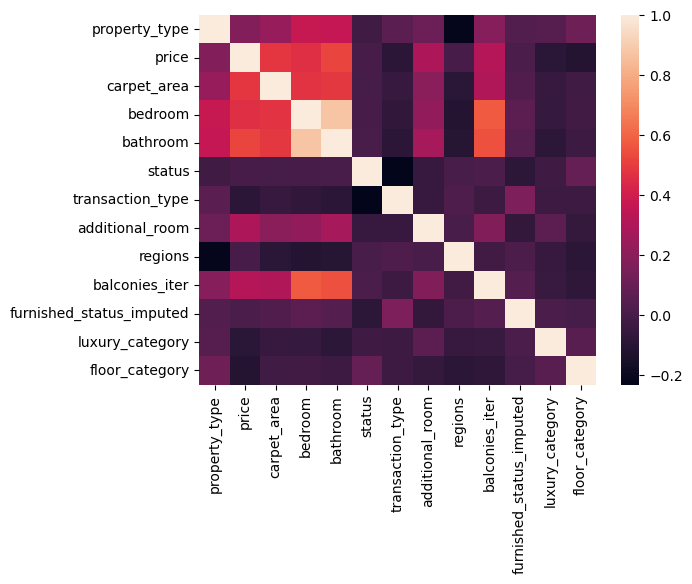

In [156]:
sns.heatmap(data_label_encoded.corr())

In [17]:
fi_df1 = data_label_encoded.corr()['price'].to_frame().reset_index().rename(columns={'index':'feature','remainder__price':'corr_coeff'})
fi_df1

,feature,price
0,property_type,0.172207
1,price,1.000000
2,carpet_area,0.482411
3,bedroom,0.463468
4,bathroom,0.520777
5,status,0.001691
6,transaction_type,-0.088351
7,additional_room,0.292492
8,regions,-0.001114
9,balconies_iter,0.313941


## Technique 2 - Random Forest Feature Importance

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df2 = pd.DataFrame({
    'feature': X_label.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

fi_df2

,feature,rf_importance
1,carpet_area,0.510144
7,regions,0.146720
3,bathroom,0.083607
11,floor_category,0.061593
0,property_type,0.043234
8,balconies_iter,0.042683
2,bedroom,0.032209
9,furnished_status_imputed,0.028353
10,luxury_category,0.022831
6,additional_room,0.016909


## Technique 3 - Gradient Boosting Feature importances

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Random Forest regressor on label encoded data
gb_label = GradientBoostingRegressor()
gb_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'feature': X_label.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
1,carpet_area,0.589829
7,regions,0.196021
11,floor_category,0.064356
3,bathroom,0.057439
2,bedroom,0.024189
0,property_type,0.017276
10,luxury_category,0.014239
6,additional_room,0.013934
8,balconies_iter,0.013359
9,furnished_status_imputed,0.007638


## Technique 4 - Permutation Importance

In [20]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': X_label.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

,feature,permutation_importance
1,carpet_area,1.310447
7,regions,0.341923
0,property_type,0.108641
11,floor_category,0.092617
8,balconies_iter,0.058256
3,bathroom,0.042490
2,bedroom,0.030467
10,luxury_category,0.022305
9,furnished_status_imputed,0.011335
6,additional_room,0.007721


## Technique 5 - LASSO

In [21]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_label)

# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y_label)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X_label.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_df5

,feature,lasso_coeff
3,bathroom,1.032372
1,carpet_area,0.899881
6,additional_room,0.427494
7,regions,0.149148
8,balconies_iter,0.024730
9,furnished_status_imputed,0.009430
4,status,0.007615
2,bedroom,0.000000
0,property_type,-0.008092
5,transaction_type,-0.120982


## Technique 6 - RFE-Recursive Feature Elimination

In [22]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X_label.shape[1], step=1)
selector_label = selector_label.fit(X_label, y_label)

# Get the selected features based on RFE
selected_features = X_label.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df6

,feature,rfe_score
1,carpet_area,0.507707
7,regions,0.146083
3,bathroom,0.087774
11,floor_category,0.065198
0,property_type,0.043969
8,balconies_iter,0.041024
2,bedroom,0.030288
9,furnished_status_imputed,0.026778
10,luxury_category,0.024183
6,additional_room,0.016168


## Technique 7 - Linear Regression Weights

In [23]:
# Train a linear regression model on the label-encoded and standardized training data
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_label)

# Extract coefficients
fi_df7 = pd.DataFrame({
    'feature': X_label.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

fi_df7

,feature,reg_coeffs
3,bathroom,1.040628
1,carpet_area,0.907095
6,additional_room,0.436218
7,regions,0.156436
8,balconies_iter,0.029586
9,furnished_status_imputed,0.022140
4,status,0.017211
2,bedroom,-0.004834
0,property_type,-0.019593
5,transaction_type,-0.129478


## Technique 8 - SHAP

In [ ]:
import shap

# Compute SHAP values using the trained Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_label, y_label)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_label)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)

shap_values

In [ ]:
fi_df8 = pd.DataFrame({
    'feature': X_label.columns,
    'SHAP_score': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_score', ascending=False)

fi_df8

## Technique 9 - Predictive Power Score

In [14]:
import ppscore as pps

pps_df = pps.matrix(df)

In [15]:
pps_df = pps_df[['x','y','ppscore']]
pps_df[(pps_df['ppscore'] > 0.4) & (pps_df['ppscore'] < 1)]

,x,y,ppscore
43,bedroom,bathroom,0.612861
50,bedroom,luxury_category,0.437989
55,bathroom,bedroom,0.539199
63,bathroom,luxury_category,0.485307


In [24]:
final_fi_df = fi_df1.merge(fi_df2,on='feature').merge(fi_df3,on='feature').merge(fi_df4,on='feature').merge(fi_df5,on='feature').merge(fi_df6,on='feature').merge(fi_df7,on='feature')

In [28]:
final_fi_df.set_index('feature', inplace=True)

In [29]:
# normalize the score
final_fi_df = final_fi_df.divide(final_fi_df.sum(axis=0), axis=1)

In [30]:
final_fi_df

,price,rf_importance,gb_importance,permutation_importance,lasso_coeff,rfe_score,reg_coeffs
feature,,,,,,,
property_type,0.088019,0.043234,0.017276,0.053434,-0.004038,0.043969,-0.009692
carpet_area,0.246573,0.510144,0.589829,0.644537,0.449084,0.507707,0.448695
bedroom,0.236891,0.032209,0.024189,0.014985,0.000000,0.030288,-0.002391
bathroom,0.266183,0.083607,0.057439,0.020898,0.515203,0.087774,0.514747
status,0.000864,0.001233,0.000006,0.000057,0.003800,0.001112,0.008513
transaction_type,-0.045159,0.010485,0.001713,0.003366,-0.060376,0.009715,-0.064046
additional_room,0.149500,0.016909,0.013934,0.003797,0.213340,0.016168,0.215775
regions,-0.000569,0.146720,0.196021,0.168173,0.074432,0.146083,0.077381
balconies_iter,0.160464,0.042683,0.013359,0.028653,0.012341,0.041024,0.014635


In [31]:
final_fi_df[['rf_importance','gb_importance','permutation_importance','rfe_score']].mean(axis=1).sort_values(ascending=False)

feature
carpet_area                 0.563054
regions                     0.164249
bathroom                    0.062430
floor_category              0.059175
property_type               0.039478
balconies_iter              0.031430
bedroom                     0.025418
luxury_category             0.018056
furnished_status_imputed    0.017086
additional_room             0.012702
transaction_type            0.006319
status                      0.000602
dtype: float64

- Conclusion :- Status and transaction_type column are contributing enough to model. So, I am going to drop status column.

In [56]:
def pearson_coefficient(x,y):
    x = np.array(x)
    y = np.array(y)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean)**2)) * np.sqrt(np.sum((y - y_mean)**2))
      
    r = numerator / denominator
    return round(r, 3)

In [ ]:
phy = [23,3,6,4,7,8,9,5,7,7]
his = [45,63,63,65,34,64,64,75,64,38]

In [45]:
np.std(phy)

21.166246714994134

In [58]:
pearson_coefficient(phy,his)

-0.39

In [59]:
# Enter your code here. Read input from STDIN. Print output to STDOUT

def pearson_coefficient(x,y):
    x = np.array(x)
    y = np.array(y)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean)**2)) * np.sqrt(np.sum((y - y_mean)**2))
      
    r = numerator / denominator
    return round(r, 3)
    
    
phy = np.array([23,44,56,34,67,86,85,54,67,87])
his = np.array([45,63,63,65,34,64,64,75,64,38])

pearson_coefficient(phy,his)


-0.097

In [ ]:
physics = [15, 12, 8, 8, 7, 7, 7, 6, 5, 3]
history = [10, 25, 17, 11, 13, 17, 20, 13, 9, 15]

n = len(physics)

mean_x = sum(physics) / n
mean_y = sum(history) / n

sum_xy = sum((physics[i] - mean_x) * (history[i] - mean_y) for i in range(n))
sum_xx = sum((physics[i] - mean_x)**2 for i in range(n))
sum_yy = sum((history[i] - mean_y)**2 for i in range(n))

r = sum_xy / (sum_xx*sum_yy)**(1/2)

print(f"{r:.3f}")